# Seattle Airbnb Project:
### What if your next group trip wasn’t just fun — but also data-optimized?

## What’s the best way for six friends to have the perfect, affordable, and smooth vacation in Seattle — all backed by real data?

### ✅ The Setup: What Are We Optimizing For?

- 👯 Group size: 6 people
- 💸 Budget: Up 1,500 USD total for 3 nights -> Q3
- 🎯 Ratings: Optimal “spot” to be determined -> Q2
- 🛏️ Comfort: Type to be determined — entire homes/apartments only or shared spaces -> Q2
- 📍 Convenience: All listings within 2 miles of each other -> Q3
- 🌤️ Timing: Month to be determined — based on affordability, weather, and availability -> Q1

## Q1. Let's find the best month to visit Seattle based on Prices, Available options, Av. Temperature and Number of Rainy Days

Start with uploading required libraries

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

## GATHER
We start by importing and loading the Airbnb dataset files:
- `calendar.csv`: Availability and pricing data
- `listings.csv`: Listing metadata
- `reviews.csv`: Guest reviews

In [193]:
calendar_df = pd.read_csv("calendar.csv")
listings_df = pd.read_csv("listings.csv")
reviews_df = pd.read_csv("reviews.csv")

# CLEAN AND ENRICH DATA

Includind add-on of weather data

In [194]:
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['month'] = calendar_df['date'].dt.month

# Filter only available listings
available_df = calendar_df[calendar_df['available'] == 't'].copy()


# Add weather data
weather_data = {
    'month': list(range(1, 13)),
    'high_temp': [47, 49, 52, 57, 63, 66, 72, 72, 67, 59, 51, 46],
    'low_temp': [39, 40, 42, 45, 50, 54, 57, 57, 55, 50, 43, 39],
    'rain_days': [13, 12, 13, 10, 7, 5, 4, 4, 5, 9, 14, 13]
}
weather_df = pd.DataFrame(weather_data)
weather_df['avg_temp'] = (weather_df['high_temp'] + weather_df['low_temp']) / 2

## ANALYZE
Data exploration includes:
- Monthly average prices, temperatures, and rain days
- Count of listings available 3+ days per month

In [195]:
# Average price per month
monthly_avg_price = available_df.groupby('month')['price'].mean()

# Listings available at least 3 days per month
listings_per_month = (
    available_df.groupby(['month', 'listing_id']).size()
    .reset_index(name='days_available')
    .query('days_available >= 3')
    .groupby('month')
    .size()
)



# Merge all data
price_series = monthly_avg_price.rename("avg_price")
listings_series = listings_per_month.rename("listings_3day")
merged = pd.DataFrame({'month': range(1, 13)})
merged = merged.merge(price_series, left_on='month', right_index=True, how='left')
merged = merged.merge(listings_series, left_on='month', right_index=True, how='left')
merged = merged.merge(weather_df, on='month', how='left')


## VISUALIZE

- Multi-axis line chart: price, listings, temperature, rain days to understand the full picture

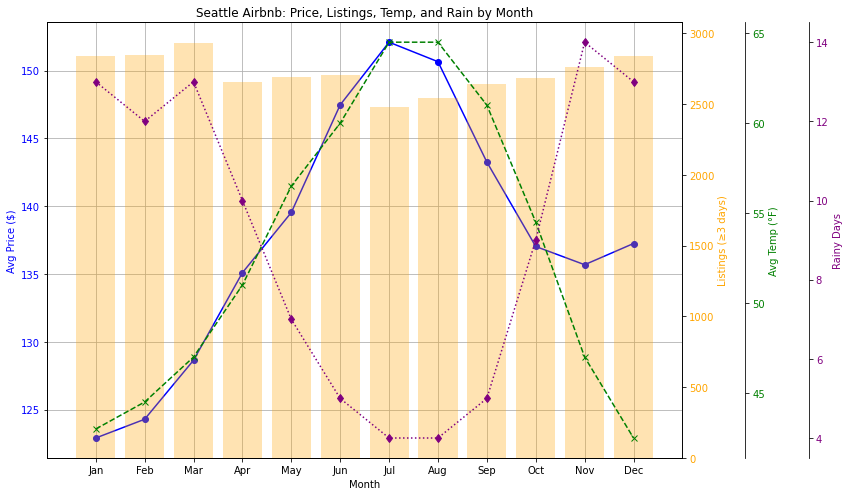

In [196]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Avg Price
ax1.plot(merged['month'], merged['avg_price'], color='blue', marker='o', label='Avg Price')
ax1.set_ylabel('Avg Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.grid(True)

# Listings Count
ax2 = ax1.twinx()
ax2.bar(merged['month'], merged['listings_3day'], alpha=0.3, color='orange')
ax2.set_ylabel('Listings (≥3 days)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Avg Temp
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))
ax3.plot(merged['month'], merged['avg_temp'], color='green', linestyle='--', marker='x')
ax3.set_ylabel('Avg Temp (°F)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Rain Days
ax4 = ax1.twinx()
ax4.spines['right'].set_position(("axes", 1.2))
ax4.plot(merged['month'], merged['rain_days'], color='purple', linestyle=':', marker='d')
ax4.set_ylabel('Rainy Days', color='purple')
ax4.tick_params(axis='y', labelcolor='purple')

# Title
plt.title('Seattle Airbnb: Price, Listings, Temp, and Rain by Month')
fig.tight_layout()
plt.show()

## MODEL
We assign scores to each month based on:
- 🏷️ Price (30%)
- 🏘️ Listings availability (20%)
- 🌡️ Average temperature (30%)
- 🌧️ Rainy days (20%)

Each score is scaled from 0 to 10 and then weighted.

In [197]:
# Scoring logic
def linear_score(value, min_val, max_val, invert=False):
    score = (value - min_val) / (max_val - min_val) * 10
    score = max(0, min(10, score))
    return 10 - score if invert else score

# Apply scores
merged['score_price'] = merged['avg_price'].apply(lambda x: linear_score(x, 300, 50))
merged['score_listings'] = merged['listings_3day'].apply(lambda x: linear_score(x, 2000, 3000))
merged['score_temp'] = merged['avg_temp'].apply(lambda x: linear_score(x, 20, 70))
merged['score_rain'] = merged['rain_days'].apply(lambda x: linear_score(x, 0, 30))

# Total weighted score
merged['total_score'] = (
    merged['score_price'] * 0.4 +
    merged['score_listings'] * 0.2 +
    merged['score_temp'] * 0.3 +
    merged['score_rain'] * 0.1
)

# Final table
score_table = merged[['month', 'avg_price', 'listings_3day', 'avg_temp', 'rain_days',
                      'score_price', 'score_listings', 'score_temp', 'score_rain', 'total_score']]

# Sort by best month
score_table_sorted = score_table.sort_values(by="total_score", ascending=False).reset_index(drop=True)
score_table_sorted

# Show table
print(score_table_sorted)

    month   avg_price  listings_3day  avg_temp  rain_days  score_price  \
0       3  128.644488           2930      47.0         13     6.854220   
1       9  143.255949           2641      61.0          5     6.269762   
2       6  147.473137           2702      60.0          5     6.101075   
3       2  124.293927           2844      44.5         12     7.028243   
4       5  139.538183           2689      56.5          7     6.418473   
5      10  137.031939           2685      54.5          9     6.518722   
6       1  122.912176           2839      43.0         13     7.083513   
7       8  150.656594           2541      64.5          4     5.973736   
8      11  135.688738           2763      47.0         14     6.572450   
9       4  135.097005           2653      51.0         10     6.596120   
10      7  152.094150           2482      64.5          4     5.916234   
11     12  137.251835           2842      42.5         13     6.509927   

    score_listings  score_temp  score

## VISUALIZE

- Bar Chart to Illustrate the Best Month to Come

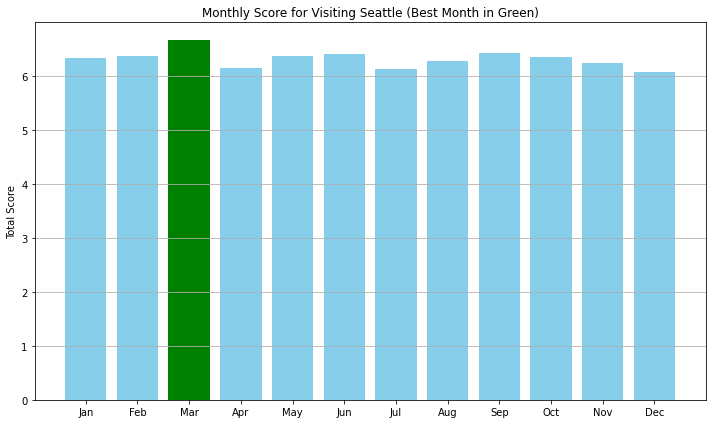

In [198]:
# Sort for display
score_table_sorted = merged.sort_values(by='total_score', ascending=False).reset_index(drop=True)

# Plot with highlight
colors = ['green' if month == score_table_sorted.iloc[0]['month'] else 'skyblue' for month in merged['month']]

plt.figure(figsize=(10, 6))
plt.bar(merged['month'], merged['total_score'], color=colors)
plt.xticks(merged['month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Score')
plt.title('Monthly Score for Visiting Seattle (Best Month in Green)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Based on our weighted model - March is the best month to visit Seattle!

## Q2. Let's analyze what type of accomodation we should choose and what level of ratings we can trust

## ANALYZE
- Frequency of room types

In [199]:
# Count room types
room_type_counts = listings_df['room_type'].value_counts().reset_index()
room_type_counts.columns = ['Room Type', 'Count']

# Identify most common room type
most_common_type = room_type_counts.iloc[0]['Room Type']

## ANALYZE
- Identify "trustful" level of ratings

In [200]:
# Calculate 80th percentile rating
percentile_80 = filtered_listings['review_scores_rating'].quantile(0.8)

## VISUALIZE

- Two Charts to drive our decision: Types of Room Distribution and Rating Distribution with 80th percerntile

<ipython-input-201-19bafd3d984b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(room_type_counts['Room Type'], rotation=45)


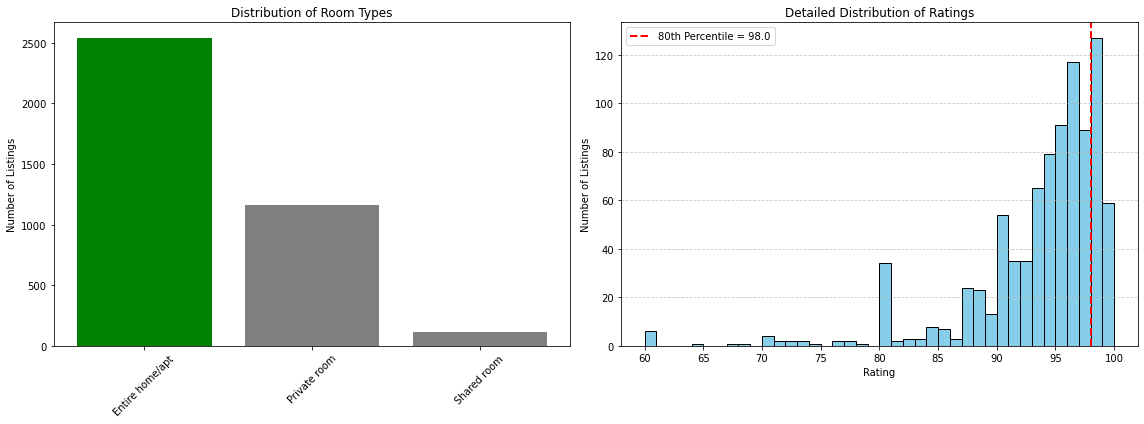

In [201]:
# Create side-by-side charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Room Type Distribution
bars = ax1.bar(room_type_counts['Room Type'], room_type_counts['Count'], color='gray')
for bar, rt in zip(bars, room_type_counts['Room Type']):
    if rt == most_common_type:
        bar.set_color('green')
ax1.set_title('Distribution of Room Types')
ax1.set_ylabel('Number of Listings')
ax1.set_xticklabels(room_type_counts['Room Type'], rotation=45)
ax1.text(most_common_type, max(room_type_counts['Count']) * 0.95, 'Most Common', ha='center', color='green')

# Chart 2: Ratings Distribution with 80th Percentile
ax2.hist(filtered_listings['review_scores_rating'], bins=range(60, 101), color='skyblue', edgecolor='black')
ax2.axvline(percentile_80, color='red', linestyle='--', linewidth=2, label=f'80th Percentile = {percentile_80:.1f}')
ax2.set_title('Detailed Distribution of Ratings')
ax2.set_xlabel('Rating')
ax2.set_ylabel('Number of Listings')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.show()

### Based on Q2 analysis we will fouc on "Entire home/apt" and top-ratings below 96

## Q3. Can we accomodate 6 friends for 3 nights in March with total budget under 1,500 USD and in the area of 2 miles using only "Entire home/apt" and not cheaper than 100 USD per day / per appartment with the listing of top rating but below 96?

Start with installing Folium - library to work with mapping capabilities

In [202]:
!pip install folium

## CLEAN
Steps to prepare our data:
- Keep only listings marked as "Entire home/apartment"
- Remove listings with suspicious (97-100)/100 ratings
- Filter listings priced under 100 USD/night
- Require at least 3 available days in March

In [203]:
# Filter for March listings available ≥3 days
march_available = calendar_df[
    (calendar_df['available'] == 't') &
    (calendar_df['month'] == 3)
]
march_counts = march_available.groupby('listing_id').size().reset_index(name='available_days')
eligible_ids = march_counts[march_counts['available_days'] >= 3]['listing_id']

# Clean price and filter listings
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
filtered_listings = listings_df[
    (listings_df['id'].isin(eligible_ids)) &
    (listings_df['room_type'] == 'Entire home/apt') &
    (listings_df['price'] >= 100) &
    (listings_df['review_scores_rating'].notna()) &
    (listings_df['review_scores_rating'] < 96) &
    (listings_df['latitude'].notna()) &
    (listings_df['longitude'].notna())
].copy()

## ANALYZE & MODEL

- Choose top listsing and match them for our criteria

In [204]:
# Top candidates
filtered_listings = filtered_listings.sort_values(by=['review_scores_rating', 'price'], ascending=[False, True])
top_group = filtered_listings[['id', 'name', 'latitude', 'longitude', 'price', 'accommodates', 'review_scores_rating']].head(50)

# Group matching function
def find_exact_guest_combinations(df, target_guests=6, max_distance_km=3.2, max_total_price=1500):
    results = []
    for r in range(2, 6):
        for combo in combinations(df.itertuples(), r):
            total_capacity = sum(l.accommodates for l in combo)
            total_price = sum(l.price for l in combo)
            if total_capacity == target_guests and total_price <= max_total_price:
                if all(
                    geodesic((l1.latitude, l1.longitude), (l2.latitude, l2.longitude)).km <= max_distance_km
                    for l1, l2 in combinations(combo, 2)
                ):
                    results.append(combo)
        if results:
            break
    return results

# Run matching
close_sets = find_exact_guest_combinations(top_group, target_guests=6, max_distance_km=3.2, max_total_price=1500)

## VISUALIZE
- Map with optimal listings
- Table with details on these listing

In [205]:
# Show results
if close_sets:
    selected_group = close_sets[0]

    # Show map with markers
    group_map = folium.Map(location=[selected_group[0].latitude, selected_group[0].longitude], zoom_start=13)
    for listing in selected_group:
        folium.Marker(
            location=[listing.latitude, listing.longitude],
            popup=f"{listing.name}<br>Accommodates: {listing.accommodates}<br>Price: ${listing.price}<br>Rating: {listing.review_scores_rating}",
            icon=folium.Icon(color="green", icon="home")
        ).add_to(group_map)

    display(group_map)

    # Show listing table
    table = pd.DataFrame([l._asdict() for l in selected_group])[[
        'name', 'accommodates', 'price', 'review_scores_rating'
    ]].rename(columns={
        'name': 'Listing Name',
        'accommodates': 'Accommodates',
        'price': 'Price ($) per night',
        'review_scores_rating': 'Rating'
    }).reset_index(drop=True)

    display(table)
else:
    print("❌ No suitable group of listings found matching all criteria.")

,Listing Name,Accommodates,Price ($) per night,Rating
0,Downtown Apt by Pike Place Market,2,100.0,95.0
1,Live downtown in luxury :),4,110.0,95.0


### ✅ TL;DR: How to Plan a Data-Backed Group Trip to Seattle
- 🗓️ Travel in March (it wins on value + weather)
- 🏡 Book entire apartments
- ⭐ Trust ratings between 90–68 (ignore ~100s)
- 💸 Filter for 100+ USD per night to avoid junk listings
- 📍 Keep your group within 2 miles for fun, shared logistics


